# DataScience project - predicting item sales in Ebay:

#### In this project we will attempt to predict the sales amount of a product in ebay. 
#### We will first scrape ebay.com and take the features we want, than we will clean it, 
#### make some more adjustments and save it into a dataframe and a csv-file for later convenient use. 
#### lastly we will use Linear Regression to try to predict a new item sales amount.



In [2]:
from bs4 import BeautifulSoup
import requests
from random import randint
from time import sleep
import pandas as pd
import numpy as np
import random
import re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import r2_score
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
url1="https://www.ebay.com/n/all-categories/"
response1 = requests.get(url1)
# we tell BeautifulSoup and tell it which parser to use
soup1 = BeautifulSoup(response1.content, "html.parser")
type(soup1)

### Crawling the main page of ebay-search and extracting all the sub categorys links into 'sub_cat_links' list:

In [ ]:
sub_cat_links = []

content_container = soup1.find('div',attrs={"class":"content-container"})
cat_containers = content_container.find_all("div",attrs={"class":"cat-container"})

#מעבר על כל קטגורייה גדולה
for cat in cat_containers:
    sub_cat_containers = cat.find_all("div",attrs={"class":"sub-cat-container"})
    sub_cat_containers = sub_cat_containers[:-3] #מחסיר את 3 המלבנים שלא רלוונטים בסוף כל קטגוריה גדולה
    
    # מעבר על כל מלבן פנימי (המלבנים שהם 3 בשורה)
    for sub_cat in sub_cat_containers:
        item_list = sub_cat.find('ul',attrs={"class":"sub-cats"})
        
        # this if is for those catagory who don't have any sub catagory (there is atleast 1)
        if item_list == None:
            continue
            
        catList = item_list.find_all('a')
        if len(catList) > 6:
            catList = catList[:-1] # without the "view more" 
            
        sub_cat_links += [t['href'] for t in catList]
        


### Crwaling each sub-category link and extracting all item links from the first two pages and saving the links
### in 'itemsLinks' list and also in 'ItemsLinks.csv' file:

In [ ]:
itemsLinks = []
#response2 = requests.session()
sub_cat_links_ref = sub_cat_links
unsuccesfulLinks = []
bigRetries = 0
flag = 1
while (unsuccesfulLinks or flag) and bigRetries <= 5:
    flag = 0
    unsuccesfulLinks = []
    bigRetries += 1
    num_of_links_to_scrape = len(sub_cat_links_ref)
    if bigRetries != 0:
        print(f"\ncurrent number of links to scrape: {num_of_links_to_scrape}\n")
    for i, link in enumerate(sub_cat_links_ref):
        if(i%10 == 0 and i!=0):
            sleeper(1)
        retries = 0
        while retries < 2:
            try:
                print(f'Attempting the {i+1}/{num_of_links_to_scrape} link for the {retries+1} time:  {link}')
                page = requests.get(link, headers=headerMaker(), timeout=15)
                break
            except requests.exceptions.RequestException as e:
                printError(e,f"there was the following error in the {i}-th link:")
                sleeper(1)
                retries += 1

        if retries == 2:
            print("*******couldnt get the page, attempting next link*******\n")
            unsuccesfulLinks.append(link)
            #del catagory_names[i]
            #del sub_cat_names[i]
            continue

        soup2 = BeautifulSoup(page.content, "html.parser")

        for j in range(2):
            print(f"*****page number: {j+1} *****")
            pageItems = soup2.find_all('div',attrs={"class":"s-item__info clearfix"})
            print(len(pageItems))
            if not pageItems:
                print("no items found on the page, lets try again in a minute")
                sleeper(0)
                try:
                    page = requests.get(link, headers=headerMaker(), timeout=15)
                    soup2 = BeautifulSoup(page.content, "html.parser")
                    pageItems = soup2.find_all('div',attrs={"class":"s-item__info clearfix"})
                except requests.exceptions.RequestException as e:
                    printError(e,"2nd attempt didn't work, attempting next link")
                    print("saves link to check later\n")
                    unsuccesfulLinks.append(link)
                    #del catagory_names[i]
                    #del sub_cat_names[i]
                    break
            if not pageItems:
                print("2nd attempt didn't work, attempting next link\n")
                unsuccesfulLinks.append(link)
                #del catagory_names[i]
                #del sub_cat_names[i]
                break
            pageItemsLinks = [t.find('a') for t in pageItems]
            itemsLinks += [t['href'] for t in pageItemsLinks]
            
            print("example of an item's link: ", pageItemsLinks[0]['href'].split('?', 1)[0])

            nextPageElement = soup2.find('a',attrs={"aria-label":"Go to next search page"})
            if j == 1 or nextPageElement == None:
                sleeper(0)
                break
            link = nextPageElement['href']
            sleeper(0)
            #print("the next page's link is :", link)
            retries1 = 0
            while retries1 < 2:
                try:
                    #current_user_agent = random.choice(headers)
                    page = requests.get(link, headers=headerMaker(), timeout=15)
                    sleeper(0)
                    break
                except requests.exceptions.RequestException as e:
                    printError(e,f"there was the following error while trying to get the 2nd page of the {i+1}-th link:")
                    sleeper(1)
                    retries1 += 1
            if retries1 == 2:
                break
            soup2 = BeautifulSoup(page.content, "html.parser")
        print("")
    
    sub_cat_links_ref = unsuccesfulLinks
    if bigRetries!=6 and unsuccesfulLinks:
        print("iteration over the links is over")
        sleep(20)
    elif not unsuccesfulLinks:
        x = len(sub_cat_links) - len(unsuccesfulLinks)
        y = len(sub_cat_links)
        print(f"\nFinished\n\nThere were {x}/{y} links scraped, success rate: {x/y:.2%}\n")
        break


#clearing all the hashset from itemLinks:
itemsLinks = [ t.split('?', 1)[0] for t in itemsLinks ]
#saving the links in df and csv-file of each item links inside each sub-category-link page:   
df2 = pd.DataFrame({'Items Links': itemsLinks})
df2.to_csv('ItemsLinks.csv')


In [ ]:
def printError(exception, text):
    print(text)
    print("******************")
    print(exception)
    print("******************")
    print("Attemping again in a minute or so...")

def sleeper(flag):
    if flag == 1:
        num = randint(12,15)
    elif flag == 0:
        num = randint(2,5)
    elif flag == 2:
        num = randint(1,2)
    elif flag == 3:
        num = round(random.uniform(0.15, 0.25), 4)
    print(f"going to sleep for {num} seconds")
    sleep(num)


def headerMaker():
    UAs = [
      'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
        ,'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
        ,'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.21244.127 Safari/537.36 Avast/113.0.21244.127'
        ,'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36 Edg/114.0.1823.51'
        ,'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'
        ,'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'
        ,'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
        ,'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
        ,'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
        ,'Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15'
        ]
    referers = ['http://www.google.com','https://www.youtube.com/watch?v=jfKfPfyJRdk','https://www.youtube.com/watch?v=Ey_vGhau7ho','https://www.amazon.com/','zenrows.com','stackoverflow.com']
    headers = {'User-Agent' : f'{random.choice(UAs)}',
        'Accept-Language' : 'en-US,en,he;q=0.5',
        'Accept-Encoding' : 'gzip, deflate, br',
        'Accept' : 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
        'Referer' : f'{random.choice(referers)}'}
    return headers 

In [ ]:
item_name = []
item_price = []
item_shipping_price = []
item_country_origin = []
item_rating = []
shop_rating = []
shop_name = []
amount_sold = []
return_time = []
delivery_time = []
item_category = []

### This function extract all the relevant features from a given item page:

In [ ]:

def getFeatures(temp_soup):
    # initializing all the item features first.
    name_f, sold_f, price_f  = None, None,  None;
    rating_f, shop_rating_f, shop_name_f = None, None, None;
    shipping_f, add_f, delivery_f= None, None, None;
    returns_f, category_f = None,None;
    # getting the item page:
    
    #getting the item name feature:
    name_soup = temp_soup.find("div",attrs={"class":"vim x-item-title"})
    if name_soup:
        name_soup = name_soup.find("span",attrs={"class":"ux-textspans ux-textspans--BOLD"})
        if name_soup:
            name_f = name_soup.get_text()
    item_name.append(name_f)
    #getting the amount of this item solded feature:
    sold_soup = temp_soup.find("div",attrs={"class":"nonActPanel"})
    if sold_soup:
        sold_soup = sold_soup.find("div",attrs={"class":"d-quantity__availability"})
        if sold_soup:
            sold_soup = sold_soup.find("div")
            if sold_soup:
                quantity_list = sold_soup.find_all("span",attrs={"class":"ux-textspans"})
                if quantity_list and len(quantity_list) >= 3:
                    sold_f = quantity_list[2].get_text()
    amount_sold.append(sold_f)
    #getting the item price feature:
    price_soup = temp_soup.find("div",attrs={"class":"x-price-primary"})
    if price_soup:
        price_soup = price_soup.find("span",attrs={"class":"ux-textspans"})
        if price_soup:
            price_f = price_soup.get_text()
    item_price.append(price_f)
    #getting the item rating feature:
    rating_soup = temp_soup.find("span",attrs={"class":"star-rating"})
    if rating_soup:
        rating_list = rating_soup.find_all("i",attrs={"class":"fullStar"})
        if rating_list:
            rating_f = len(rating_list)
    item_rating.append(rating_f)
    #getting the shop rating feature:
    shop_soup = temp_soup.find("div",attrs={"class":"d-stores-info-categories__container__info__section__item"})
    if shop_soup:
        shop_soup = shop_soup.find("span",attrs={"class":"ux-textspans ux-textspans--BOLD"})
        if shop_soup and "%" in shop_soup.get_text():
            shop_rating_f = shop_soup.get_text()
    shop_rating.append(shop_rating_f)
    #getting the shop name feature:
    shop_soup2 = temp_soup.find("div",attrs={"class":"d-stores-info-categories__container__info__section__title"})
    if shop_soup2:
        shop_soup2 = shop_soup2.find("span",attrs={"class":"ux-textspans ux-textspans--BOLD"})
        if shop_soup2:
            shop_name_f = shop_soup2.get_text()
    shop_name.append(shop_name_f)
    #getting the item shipping price feature:
    shipping_soup = temp_soup.find("div",attrs={"class":"ux-labels-values col-12 ux-labels-values--shipping"})
    if shipping_soup:
        shipping_soup = shipping_soup.find("span",attrs={"class":"ux-textspans ux-textspans--BOLD"})
        if shipping_soup:
            shipping_f = shipping_soup.get_text()
    item_shipping_price.append(shipping_f)
    #getting the item country origin feature:
    origin_soup = temp_soup.find("div",attrs={"class":"ux-labels-values col-12 ux-labels-values--legalShipping"})
    if origin_soup:
        address_soup = origin_soup.find("div",attrs={"class":"ux-labels-values__values-content"})
        if address_soup:
            address_list = address_soup.find_all("span",attrs={"class":"ux-textspans ux-textspans--SECONDARY"})
            if address_list:
                for add in address_list:
                    add_f = add.get_text()
                    if "Located in:" in add_f:
                        add_f = add_f[12:]
                        break
    item_country_origin.append(add_f)
    #getting the item delivery time feature:
    delivery_soup = temp_soup.find("div",attrs={"class":"ux-labels-values col-12 ux-labels-values__column-last-row ux-labels-values--deliverto"})
    if delivery_soup:
        delivery_soup = delivery_soup.find("span",attrs={"class":"ux-textspans ux-textspans--SECONDARY ux-textspans--BOLD"})
        if delivery_soup:
            delivery_f = delivery_soup.get_text()
    delivery_time.append(delivery_f)
    # getting the returns time of the item:
    returns_soup = temp_soup.find("div",attrs={"class":"ux-labels-values col-12 ux-labels-values__column-last-row ux-labels-values--returns"})
    if returns_soup:
        returns_list = returns_soup.find_all("span", attrs={"class":"ux-textspans"})
        if returns_list:
            for i in returns_list:
                returns_f = i.get_text()
                if "returns" in returns_f:
                    break
    return_time.append(returns_f)
    # getting item category:
    category_soup = temp_soup.find_all("a",attrs={"class":"seo-breadcrumb-text"})
    if category_soup:
        category_soup = category_soup[0].find("span")
        if category_soup:
            category_f = category_soup.get_text()
    item_category.append(category_f)
        

### This section scraping all items links and extract all the relavant features,
### and save all data in dataframe and 'EbayData.csv' file:

In [ ]:
unsuccesfulItems = []
flag1 = 1
scrapingRetries = 0
itemsLinksRef = itemsLinks
while (unsuccesfulItems or flag1) and scrapingRetries <= 5:
    flag1 = 0
    unsuccesfulItems = []
    scrapingRetries += 1
    num_of_links_to_scrape1 = len(itemsLinksRef)
    for idx, itemLink in enumerate(itemsLinksRef):
        reqRetries = 0
        if idx%10000 == 0 and idx!=0:
            ebayDataDf = pd.DataFrame({"Item Name":item_name ,"Price":item_price,"Country Origin":item_country_origin ,"Item Rating":item_rating ,
                                "Seller Name":shop_name,"Seller Rating":shop_rating ,"Amount Sold":amount_sold ,"Return Time":return_time ,
                                "Delivery Time":delivery_time ,"Item Category":item_category ,
                                "Shipping Price":item_shipping_price })
            ebayDataDf.to_csv(f'EbayData{idx}.csv')
        while reqRetries < 2:
            try:
                print(f'Attempting the {idx+1}/{num_of_links_to_scrape1} link for the {reqRetries+1} time:  {itemLink}')
                response3 = requests.get(itemLink, headers=headerMaker(), timeout=15)
                page = BeautifulSoup(response3.content, "html.parser")
                print("Success! getting the features and moving to the next link")
                getFeatures(page)
                #sleeper(3)
                print("")
                break
            except requests.exceptions.RequestException as e:
                printError(e,f"there was the following error in the {idx+1}-th link:")
                sleeper(0)
                reqRetries += 1

        if reqRetries == 2:
            print("*******couldnt get the page, attempting next link*******\n")
            unsuccesfulItems.append(itemLink)
            continue
        
        
    itemsLinksRef = unsuccesfulItems
    if reqRetries!=6 and unsuccesfulItems:
        print("\ncurrent iteration over the links is over")
        sleeper(0)
        print("")
    elif not unsuccesfulItems:
        x = len(itemsLinks) - len(unsuccesfulItems)
        y = len(itemsLinks)
        print(f"\n\nFinished\n\nThere were {x}/{y} links scraped, success rate: {x/y:.2%}\n")
        break
ebayDataDf = pd.DataFrame({"Item Name":item_name ,"Price":item_price,"Country Origin":item_country_origin ,"Item Rating":item_rating ,
                    "Seller Name":shop_name,"Seller Rating":shop_rating ,"Amount Sold":amount_sold ,"Return Time":return_time ,
                    "Delivery Time":delivery_time ,"Item Category":item_category ,
                    "Shipping Price":item_shipping_price })

ebayDataDf.to_csv('EbayData.csv')

        

### Using the ready EbayCsv file:

In [3]:
ebayDataDf = pd.read_csv("EbayData.csv",index_col=0)

In [4]:
ebayDataDf2 = ebayDataDf.drop_duplicates()
ebayDataDf2 = ebayDataDf2[ebayDataDf2['Amount Sold'].notnull()]
ebayDataDf2 = ebayDataDf2.dropna(thresh=5)
ebayDataDf2.head(50)

,Item Name,Price,Country Origin,Item Rating,Seller Name,Seller Rating,Amount Sold,Return Time,Delivery Time,Item Category,Shipping Price
0,"Harley FL Spotlight Trim 4-1/2"" Chrome Bullet ...",US $58.99,NaN,5.0,ALPINE AUTO,99.9%,33 sold,30 days returns,greater than 16 business days.,eBay Motors,US $17.43
1,"Royal Enfield ""LOW RIDER SEAT"" For CLASSIC 350...",GBP 54.00,"New Delhi, India, India",5.0,royal-rider,96.5%,9 sold,30 days returns,greater than 10 business days.,eBay Motors,Free
2,"2 Lucas 700 Headlight 7"" 12V Conversion Lamp H...",US $37.65,"DELHI, DELHI, India",NaN,SCOOTERSHOP9910,93.4%,12 sold,60 days returns,greater than 11 business days.,eBay Motors,Free
3,1pcs Motorcycle Gear Shift Lever Shifter Pedal...,US $24.99,"Beijing, China",NaN,qingch256,90.5%,32 sold,30 days returns,greater than 25 business days.,eBay Motors,Free
4,"METALLIC, E-MARKED, EXHAUST STICKER (60mm x 2...",GBP 3.99,"Folkestone, United Kingdom",NaN,staff40racing,100%,154 sold,30 days returns,NaN,eBay Motors,GBP 4.00
5,FOR KAWASAKI EX250 F Ninja 250R Carburetor Rep...,US $17.90/ea,"qingdaoshi, China",NaN,huahaofangzhoukeji,99.4%,165 sold,30 days returns,NaN,eBay Motors,US $2.00
7,Lot Set of 120 Motorcycle Motocross Decals Sti...,US $10.99,"Guangzhou, China",NaN,Young989264,99.2%,454 sold,30 days returns,greater than 20 business days.,eBay Motors,Free
8,39~200cm DOT Motorcycle Motorbike Braided Stee...,GBP 7.58,"Guangzhou, China",NaN,linkssey684-8,98.3%,330 sold,30 days returns,greater than 20 business days.,eBay Motors,Free
9,FOR Suzuki VS1400 VS800 VS800GL VZ800 Carburet...,US $17.34/ea,"qingdaoshi, China",NaN,huahaofangzhoukeji,99.4%,63 sold,30 days returns,NaN,eBay Motors,US $2.00
10,"Cardo Systems Freecom 4X Single,Black",US $163.23,NaN,5.0,G&G Liqudation,94.5%,31 sold,30 days returns,greater than 17 business days.,eBay Motors,US $25.40


In [5]:
ebayDataDf2 = ebayDataDf2.copy()

#Handling Country feature:
ebayDataDf2['Country Origin'].fillna(value='Unknown Country',inplace=True)
ebayDataDf2.loc[:,'Country Origin'] = ebayDataDf2.loc[:,'Country Origin'].apply(lambda x: x.split(",")[-1])

#Handling Price feature:
    # clearing two items without price column.
ebayDataDf2 = ebayDataDf2[ebayDataDf2['Price'].notnull()] #drop price empty lines.
ebayDataDf2.loc[:,'Price-Number'] = ebayDataDf2.loc[:,'Price'].apply(lambda x: x.split(" ")[1]) #split price to 2 columns:
ebayDataDf2.loc[:,'Currency'] = ebayDataDf2.loc[:,'Price'].apply(lambda x: x.split(" ")[0])
    # Find the indices where 'Price-Number' equals 'PLN'
indxes = ebayDataDf2[ebayDataDf2['Price-Number'] == 'PLN'].index
    # Swap values between 'Price-Number' and 'Currency' at the specified indices
ebayDataDf2.loc[indxes, ['Price-Number', 'Currency']] = ebayDataDf2.loc[indxes, ['Currency', 'Price-Number']].values
    # Extract numeric values from 'currency' column
ebayDataDf2.loc[:,'Price-Number'] = ebayDataDf2.loc[:,'Price-Number'].apply(lambda x: re.findall(r'(\d+\.?\d*)', str(x))[0])
    # Convert 'currency' column to numeric type
ebayDataDf2.loc[:,'Price-Number'] = pd.to_numeric(ebayDataDf2.loc[:,'Price-Number'])
    # Define the multiplication factors
conversion_factors = {'US': 1, 'GBP': 1.27, 'EUR': 1.1, 'AU': 0.68, 'C': 0.76, 'PLN': 0.25}
    # Multiply the numbers in 'price' column based on the values in 'currency' column
ebayDataDf2.loc[:,'Price'] = ebayDataDf2.apply(lambda row: row['Price-Number'] * conversion_factors[row['Currency']], axis=1)
    # deleting the helper columns
ebayDataDf2 = ebayDataDf2.drop(['Price-Number','Currency'], axis=1)

#Handling Shipping Price feature:
ebayDataDf2.loc[:, 'Shipping Price'] = ebayDataDf2.loc[:, 'Shipping Price'].replace(['Free', None], ['US 0', 'US 0'])
ebayDataDf2['Price-Number'] = ebayDataDf2.loc[:,'Shipping Price'].apply(lambda x: x.split(" ")[1]) #split price to 2 columns:
ebayDataDf2['Currency'] = ebayDataDf2.loc[:,'Shipping Price'].apply(lambda x: x.split(" ")[0])
    # Find the indices where 'Price-Number' equals 'PLN'
indxes = ebayDataDf2[ebayDataDf2['Price-Number'] == 'PLN'].index
    # Swap values between 'Price-Number' and 'Currency' at the specified indices
ebayDataDf2.loc[indxes, ['Price-Number', 'Currency']] = ebayDataDf2.loc[indxes, ['Currency', 'Price-Number']].values
    # Extract numeric values from 'currency' column
ebayDataDf2.loc[:,'Price-Number'] = ebayDataDf2.loc[:,'Price-Number'].apply(lambda x: re.findall(r'(\d+\.?\d*)', str(x))[0])
    # Convert 'currency' column to numeric type
ebayDataDf2.loc[:,'Price-Number'] = pd.to_numeric(ebayDataDf2.loc[:,'Price-Number'])
    # Define the multiplication factors
conversion_factors = {'US': 1, 'GBP': 1.27, 'EUR': 1.1, 'AU': 0.68, 'C': 0.76, 'PLN': 0.25}
    # Multiply the numbers in 'price' column based on the values in 'currency' column
ebayDataDf2.loc[:,'Shipping Price'] = ebayDataDf2.apply(lambda row: row['Price-Number'] * conversion_factors[row['Currency']], axis=1)
    # deleting the helper columns
ebayDataDf2 = ebayDataDf2.drop(['Price-Number','Currency'], axis=1)

#Handling Seller Rating feature:
temp = ebayDataDf2[ebayDataDf2['Seller Rating'].notnull()]
temp.loc[:,'Seller Rating'] = temp.loc[:,'Seller Rating'].apply(lambda x: re.findall(r'(\d+\.?\d*)', str(x))[0])
    # Convert 'currency' column to numeric type
temp.loc[:,'Seller Rating'] = pd.to_numeric(temp.loc[:,'Seller Rating'])
columnMean = round(temp['Seller Rating'].mean(),1)
ebayDataDf2.loc[:, 'Seller Rating'] = ebayDataDf2.loc[:, 'Seller Rating'].fillna(value=str(columnMean))
ebayDataDf2.loc[:,'Seller Rating'] = ebayDataDf2.loc[:,'Seller Rating'].apply(lambda x: re.findall(r'(\d+\.?\d*)', str(x))[0])
ebayDataDf2.loc[:,'Seller Rating'] = pd.to_numeric(ebayDataDf2.loc[:,'Seller Rating'])

#Handling Return Time feature:
conversion_factors = {'30 days returns': 30, '60 days returns': 60, 'Seller does not accept returns': 0, '14 days returns': 14,
                      '1 month returns': 30, '3 days returns': 3, None: 0,
                     "Seller does not accept returns. If the item you received doesn't match the listing description, your purchase may be eligible for ": 0}
    # Multiply the numbers in 'price' column based on the values in 'currency' column
ebayDataDf2.loc[:,'Return Time'] = ebayDataDf2.replace({"Return Time": conversion_factors})

#Handling Item Rating feature:
ebayDataDf2.loc[:,'Item Rating'] = ebayDataDf2.loc[:,'Item Rating'].fillna(value='0')
ebayDataDf2.loc[:,'Item Rating'] = pd.to_numeric(ebayDataDf2.loc[:,'Item Rating'])

#Handling Amount Sold feature:
ebayDataDf2.loc[:,'Amount Sold'] = ebayDataDf2.loc[:,'Amount Sold'].apply(lambda x: re.findall(r'(\d+\.?\d*)', str(x))[0])
ebayDataDf2.loc[:,'Amount Sold'] = pd.to_numeric(ebayDataDf2.loc[:,'Amount Sold'])

#Handling Delivery Time feature:
def DeliveryTimeHelper(t):
    li = re.findall(r'than (\d+\.?\d*)', str(t))
    if li:
        return int(li[0])
    li = re.findall(r'(\d+\.?\d*) business days', str(t))
    if li:
        return 5

ebayDataDf2.loc[:,'Delivery Time changed'] = ebayDataDf2.loc[:,'Delivery Time']
ebayDataDf2.loc[:,'Delivery Time changed'] = ebayDataDf2.loc[:,'Delivery Time changed'].apply(DeliveryTimeHelper)
bins = [1,7,14,21,30,40,50,60,70]
labels = [7,14,21,30,40,50,60,70]
temp1 = pd.cut(ebayDataDf2[ebayDataDf2['Delivery Time changed'].notnull()]['Delivery Time changed'], bins, labels=labels)
temp2 = pd.to_numeric(temp1)
columnMean1 = round(temp2.mean())
ebayDataDf2.loc[:, 'Delivery Time changed'] = ebayDataDf2.loc[:, 'Delivery Time changed'].fillna(columnMean1)
ebayDataDf2['Delivery Time_binned'] = pd.cut(ebayDataDf2['Delivery Time changed'], bins, labels=labels)

C:\Users\elira\AppData\Local\Temp\ipykernel_34296\2849339295.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ebayDataDf2.loc[:,'Price-Number'] = pd.to_numeric(ebayDataDf2.loc[:,'Price-Number'])
C:\Users\elira\AppData\Local\Temp\ipykernel_34296\2849339295.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ebayDataDf2.loc[:,'Price'] = ebayDataDf2.apply(lambda row: row['Price-Number'] * conversion_factors[row['Currency']], axis=1)
C:\Users\elira\AppData\Local\Temp\ipykernel_34296\2849339295.py:38: DeprecationWarning: In a future version

In [6]:
ebayDataDf2

,Item Name,Price,Country Origin,Item Rating,Seller Name,Seller Rating,Amount Sold,Return Time,Delivery Time,Item Category,Shipping Price,Delivery Time changed,Delivery Time_binned
0,"Harley FL Spotlight Trim 4-1/2"" Chrome Bullet ...",58.9900,Unknown Country,5.0,ALPINE AUTO,99.9,33,30,greater than 16 business days.,eBay Motors,17.43,16.0,21
1,"Royal Enfield ""LOW RIDER SEAT"" For CLASSIC 350...",68.5800,India,5.0,royal-rider,96.5,9,30,greater than 10 business days.,eBay Motors,0.00,10.0,14
2,"2 Lucas 700 Headlight 7"" 12V Conversion Lamp H...",37.6500,India,0.0,SCOOTERSHOP9910,93.4,12,60,greater than 11 business days.,eBay Motors,0.00,11.0,14
3,1pcs Motorcycle Gear Shift Lever Shifter Pedal...,24.9900,China,0.0,qingch256,90.5,32,30,greater than 25 business days.,eBay Motors,0.00,25.0,30
4,"METALLIC, E-MARKED, EXHAUST STICKER (60mm x 2...",5.0673,United Kingdom,0.0,staff40racing,100.0,154,30,NaN,eBay Motors,5.08,19.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50619,2021/22 UEFA Champions League Real Madrid Gold...,13.9900,Unknown Country,0.0,footballpatches17,100.0,141,30,greater than 14 business days.,Sporting Goods,13.43,14.0,14
50620,2023 Will Smith Dodgers Catcher SGA Bobblehead...,36.7500,Unknown Country,0.0,Bobbleheads and Collectibles,100.0,17,30,greater than 14 business days.,Sporting Goods,26.96,14.0,14
50621,NEW Dallas Cowboys Men’s with Pockets Deep Blu...,26.8000,China,0.0,yiche_2885,100.0,30,0,greater than 11 business days.,Sporting Goods,5.00,11.0,14
50623,Chicago Bears NEW Football Shorts Stitched Cla...,10.9900,Hong Kong,0.0,kekuoq-38,100.0,8,0,greater than 11 business days.,Sporting Goods,0.00,11.0,14


In [7]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder 
# Creating a instance of label Encoder.
le = LabelEncoder()
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(ebayDataDf2['Country Origin'])
# Appending the array to our dataFrame
# with column name 'Country Origin label'
ebayDataDf2["Country Origin labeled"] = label 
# Using .fit_transform function to fit label
# encoder and return encoded label
label2 = le.fit_transform(ebayDataDf2['Item Category'])
# Appending the array to our dataFrame
# with column name 'Country Origin label'
ebayDataDf2["Item Category labeled"] = label2 
# printing Dataframe
ebayDataDf2

,Item Name,Price,Country Origin,Item Rating,Seller Name,Seller Rating,Amount Sold,Return Time,Delivery Time,Item Category,Shipping Price,Delivery Time changed,Delivery Time_binned,Country Origin labeled,Item Category labeled
0,"Harley FL Spotlight Trim 4-1/2"" Chrome Bullet ...",58.9900,Unknown Country,5.0,ALPINE AUTO,99.9,33,30,greater than 16 business days.,eBay Motors,17.43,16.0,21,74,18
1,"Royal Enfield ""LOW RIDER SEAT"" For CLASSIC 350...",68.5800,India,5.0,royal-rider,96.5,9,30,greater than 10 business days.,eBay Motors,0.00,10.0,14,27,18
2,"2 Lucas 700 Headlight 7"" 12V Conversion Lamp H...",37.6500,India,0.0,SCOOTERSHOP9910,93.4,12,60,greater than 11 business days.,eBay Motors,0.00,11.0,14,27,18
3,1pcs Motorcycle Gear Shift Lever Shifter Pedal...,24.9900,China,0.0,qingch256,90.5,32,30,greater than 25 business days.,eBay Motors,0.00,25.0,30,13,18
4,"METALLIC, E-MARKED, EXHAUST STICKER (60mm x 2...",5.0673,United Kingdom,0.0,staff40racing,100.0,154,30,NaN,eBay Motors,5.08,19.0,21,70,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50619,2021/22 UEFA Champions League Real Madrid Gold...,13.9900,Unknown Country,0.0,footballpatches17,100.0,141,30,greater than 14 business days.,Sporting Goods,13.43,14.0,14,74,14
50620,2023 Will Smith Dodgers Catcher SGA Bobblehead...,36.7500,Unknown Country,0.0,Bobbleheads and Collectibles,100.0,17,30,greater than 14 business days.,Sporting Goods,26.96,14.0,14,74,14
50621,NEW Dallas Cowboys Men’s with Pockets Deep Blu...,26.8000,China,0.0,yiche_2885,100.0,30,0,greater than 11 business days.,Sporting Goods,5.00,11.0,14,13,14
50623,Chicago Bears NEW Football Shorts Stitched Cla...,10.9900,Hong Kong,0.0,kekuoq-38,100.0,8,0,greater than 11 business days.,Sporting Goods,0.00,11.0,14,24,14


### EDA: looking at each feature alone:

<Axes: ylabel='Return Time'>

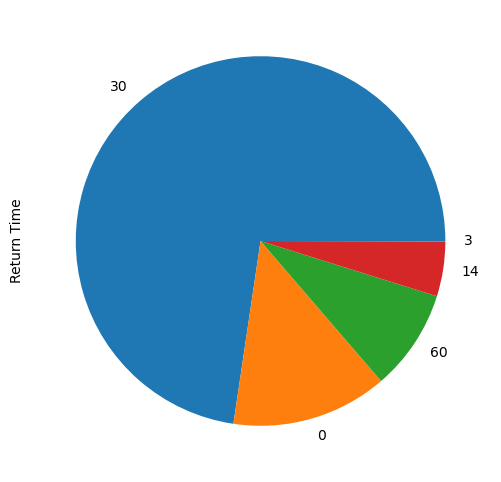

In [9]:
ebayDataDf2['Return Time'].value_counts().plot(kind='pie')

Text(0, 0.5, 'Frequency')

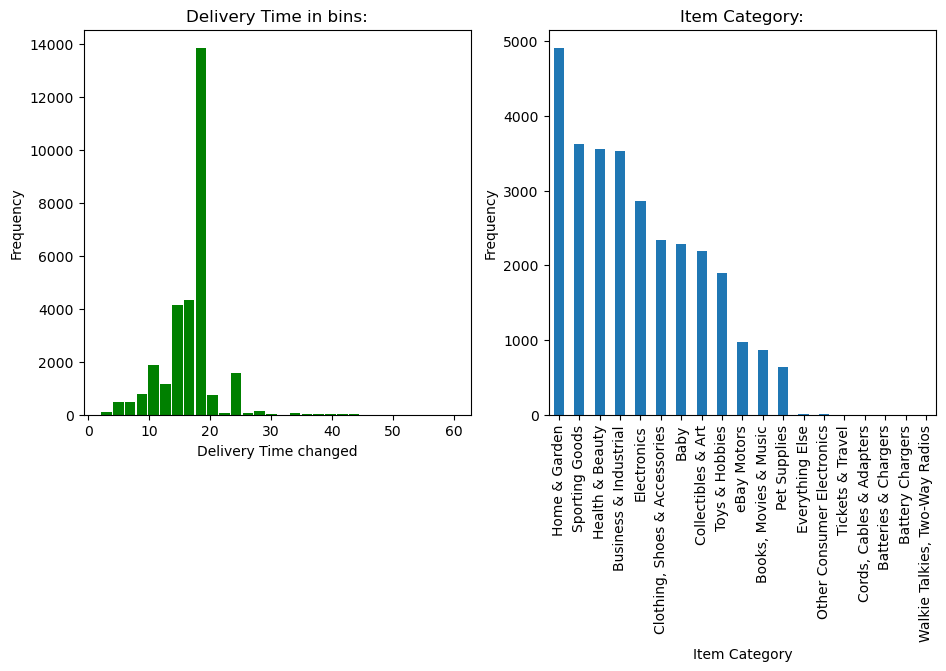

In [10]:
fig1 = plt.figure(figsize=(11, 5))
fig11 = fig1.add_subplot(1,2,1)
fig12 = fig1.add_subplot(1,2,2)
fig11.hist(ebayDataDf2['Delivery Time changed'],bins=30, rwidth=0.9, color='green')
fig11.set_title('Delivery Time in bins:')
fig11.set_xlabel('Delivery Time changed')
fig11.set_ylabel('Frequency')

fig12 = ebayDataDf2['Item Category'].value_counts().plot(kind='bar')
fig12.set_title('Item Category:')
fig12.set_xlabel('Item Category')
fig12.set_ylabel('Frequency')


Text(0.5, 1.0, 'Shipping Price')

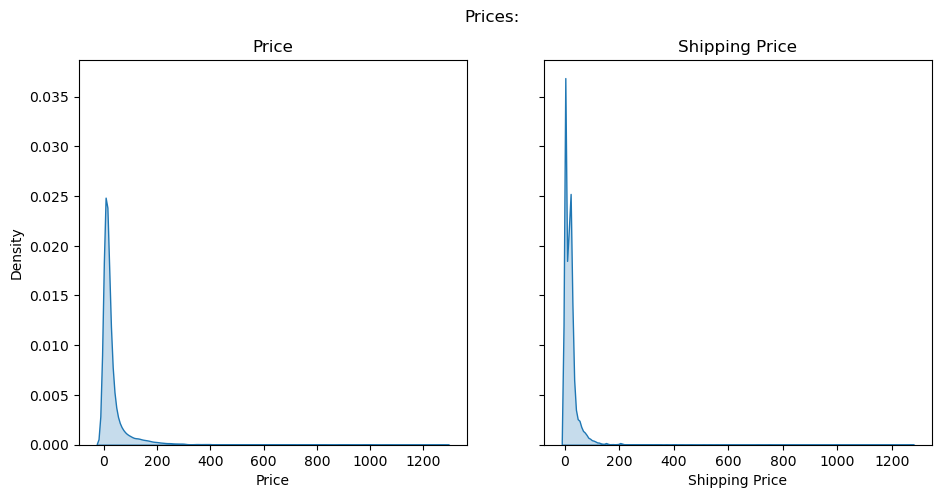

In [11]:
fig2, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
fig2.suptitle('Prices:')

sns.kdeplot(ebayDataDf2['Price'], fill=True, ax=axes[0])
axes[0].set_title('Price')

sns.kdeplot(ebayDataDf2['Shipping Price'], fill=True, ax=axes[1])
axes[1].set_title('Shipping Price')

### EDA: at least two dimentition visualization:

<Axes: xlabel='Amount Sold', ylabel='Item Category'>

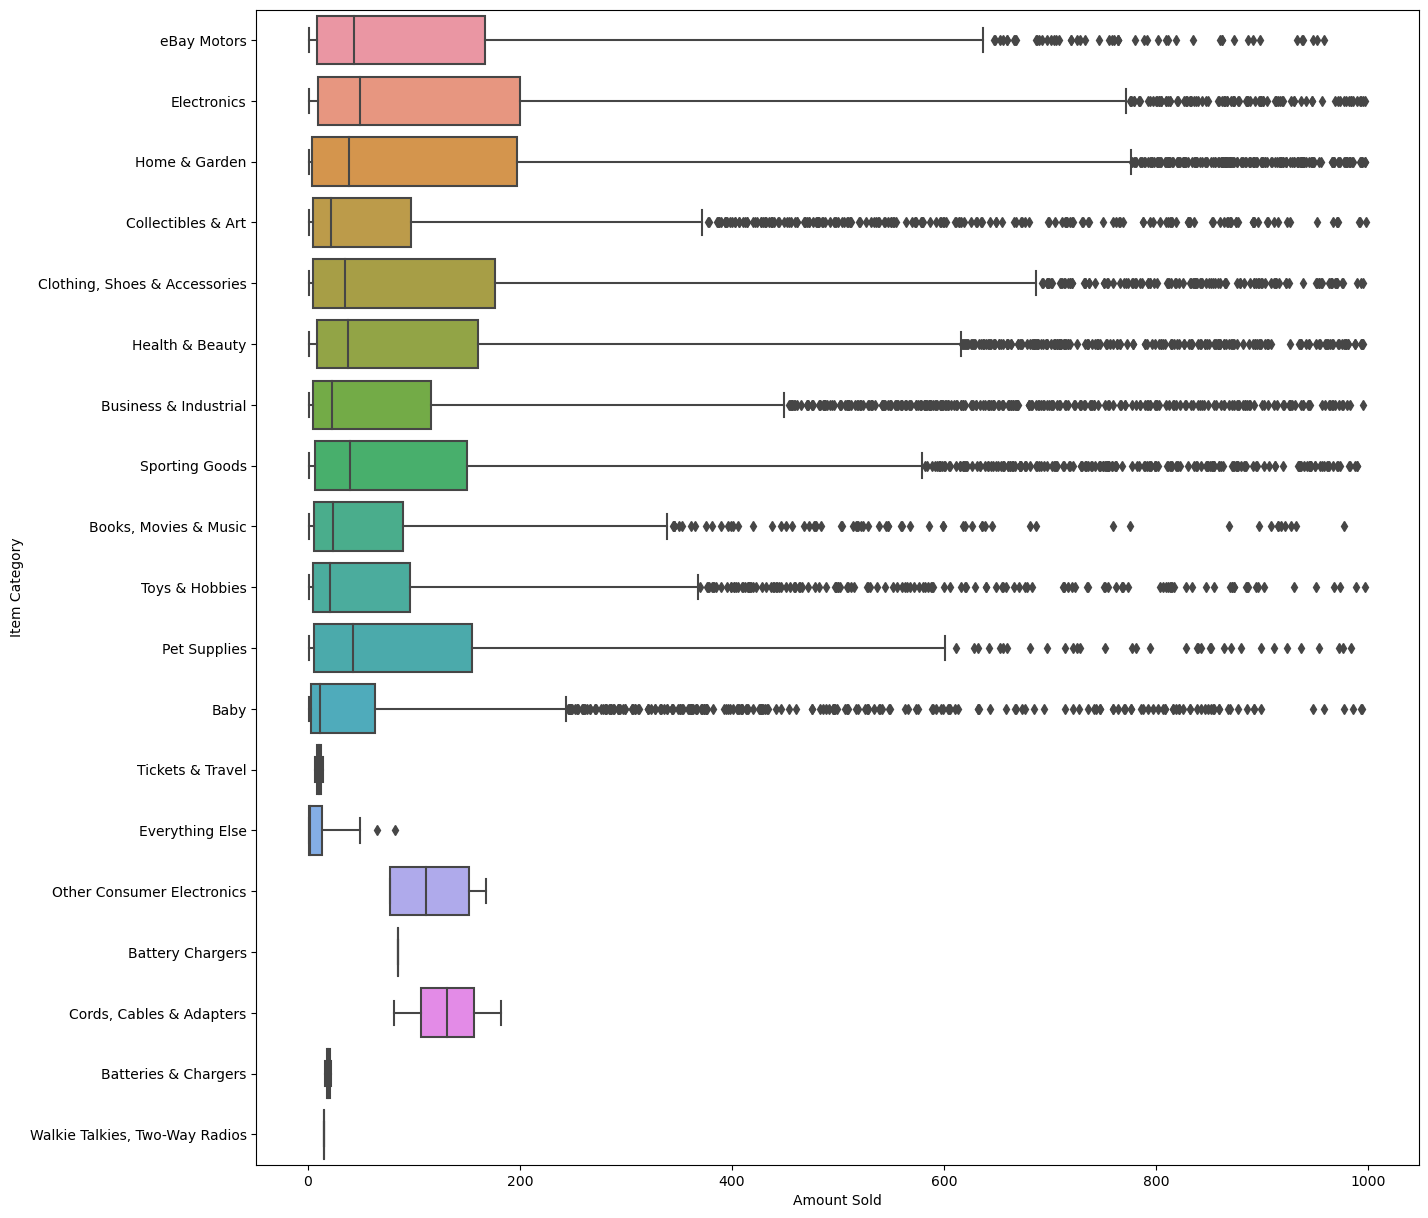

In [13]:
fig_c= plt.figure(figsize=(15, 15))
sns.boxplot(y=ebayDataDf2['Item Category'],x=ebayDataDf2['Amount Sold'],whis=3)

C:\Users\elira\AppData\Local\Temp\ipykernel_34296\759039002.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  p1=ebayDataDf2.groupby(['Item Category']).mean()[['Amount Sold','Price','Shipping Price']]


<Axes: xlabel='Item Category'>

<Figure size 500x1100 with 0 Axes>

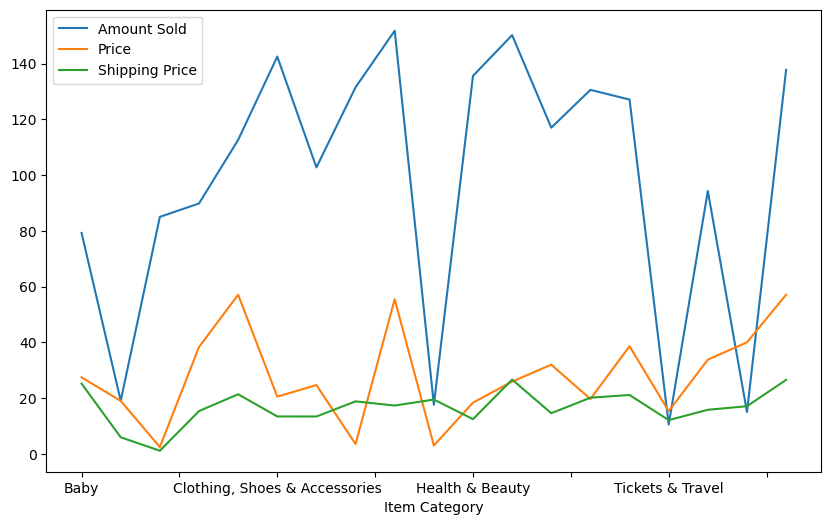

In [14]:
p1=ebayDataDf2.groupby(['Item Category']).mean()[['Amount Sold','Price','Shipping Price']]
plt.figure(figsize=(5, 11))
p1.plot()  #kind=line can be skipped, since this is the default for the kind parameter

<Axes: xlabel='Price', ylabel='Amount Sold'>

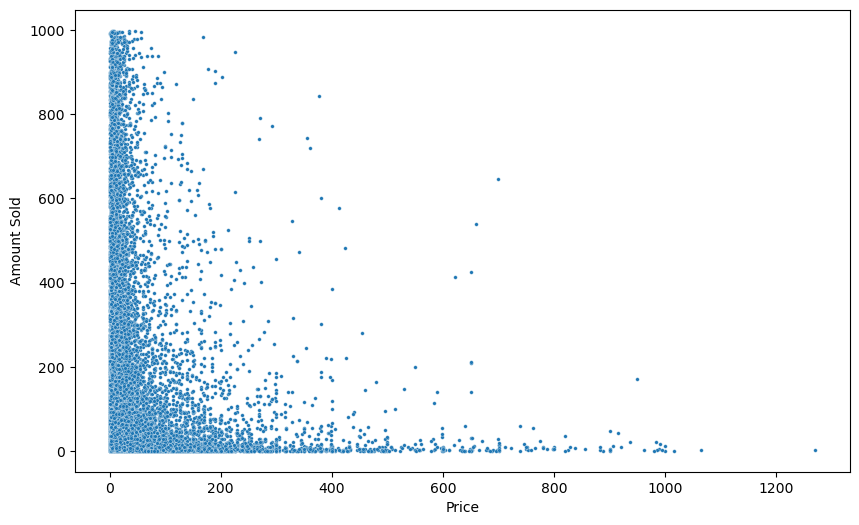

In [15]:
sns.scatterplot(x='Price',y='Amount Sold', s=7,data=ebayDataDf2)

In [17]:
ebayDataDf2["TotalPrice"]=ebayDataDf2["Shipping Price"]+ebayDataDf2["Price"]
ebayDataDf2["MultyPrice"]=ebayDataDf2["Shipping Price"]*ebayDataDf2["Price"]

In [18]:
#ebayDataDf2[['Price','Amount Sold','Shipping Price','Return Time','Delivery Time changed']].corr()
ebayDataDf2.select_dtypes(include=np.number).corr()

,Price,Item Rating,Seller Rating,Amount Sold,Return Time,Shipping Price,Delivery Time changed,Country Origin labeled,Item Category labeled,TotalPrice,MultyPrice
Price,1.000000,0.098921,0.008756,-0.095511,-0.052838,0.315516,-0.105848,0.058506,-0.007142,0.943174,0.575548
Item Rating,0.098921,1.000000,0.035270,0.026010,0.014846,0.085357,-0.053952,0.118732,0.038415,0.112261,0.041549
Seller Rating,0.008756,0.035270,1.000000,0.048225,-0.013551,0.083969,-0.029619,0.216976,0.001645,0.036696,0.012881
Amount Sold,-0.095511,0.026010,0.048225,1.000000,0.025596,0.000812,0.011251,0.095122,0.048143,-0.079246,-0.039204
Return Time,-0.052838,0.014846,-0.013551,0.025596,1.000000,-0.054654,0.163268,-0.066586,-0.040680,-0.063137,-0.035395
Shipping Price,0.315516,0.085357,0.083969,0.000812,-0.054654,1.000000,-0.058308,0.346576,0.015135,0.612913,0.576796
Delivery Time changed,-0.105848,-0.053952,-0.029619,0.011251,0.163268,-0.058308,1.000000,-0.066638,-0.048638,-0.108557,-0.037026
Country Origin labeled,0.058506,0.118732,0.216976,0.095122,-0.066586,0.346576,-0.066638,1.000000,0.008069,0.170084,0.076212
Item Category labeled,-0.007142,0.038415,0.001645,0.048143,-0.040680,0.015135,-0.048638,0.008069,1.000000,-0.000647,0.003213
TotalPrice,0.943174,0.112261,0.036696,-0.079246,-0.063137,0.612913,-0.108557,0.170084,-0.000647,1.000000,0.681236


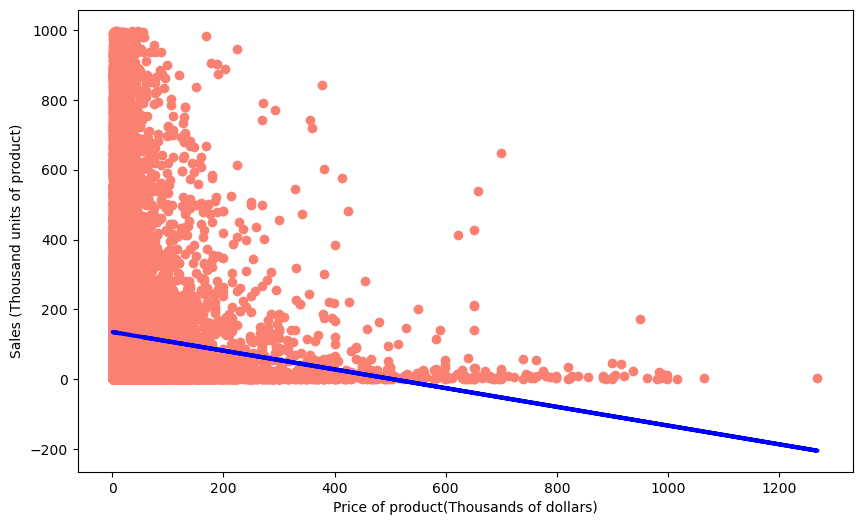

Slope: [[-0.26808881]]
Intercept: [135.14802551]
R2: 0.009122410019175131


In [19]:
lr_price = linear_model.LinearRegression() # create a linear regression object
x = ebayDataDf2['Price'].values.reshape(ebayDataDf2['Price'].shape[0],1)
y = ebayDataDf2['Amount Sold'].values.reshape(ebayDataDf2['Amount Sold'].shape[0],1)
lr_price.fit(X=x, y=y)

plt.scatter(x, y,  color='salmon')
plt.plot(x, lr_price.predict(x), color='blue', linewidth=3)

plt.xlabel('Price of product(Thousands of dollars)')
plt.ylabel('Sales (Thousand units of product)')
plt.show()

print("Slope:",lr_price.coef_)
print("Intercept:",lr_price.intercept_)
print("R2:",lr_price.score(x,y))

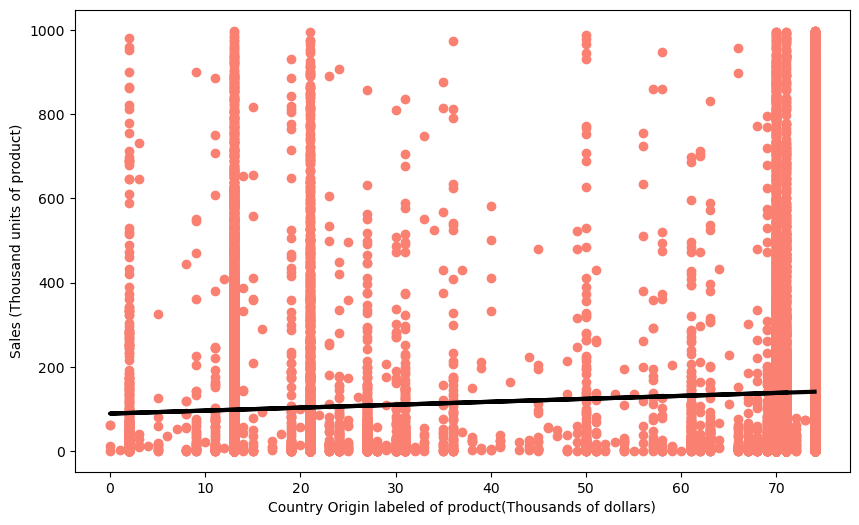

Slope: [[0.70030455]]
Intercept: [89.19722603]
R2: 0.009048115771923992


In [21]:
lr_origin = linear_model.LinearRegression() # create a linear regression object
x = ebayDataDf2['Country Origin labeled'].values.reshape(ebayDataDf2['Country Origin labeled'].shape[0],1)
y = ebayDataDf2['Amount Sold'].values.reshape(ebayDataDf2['Amount Sold'].shape[0],1)
lr_origin.fit(X=x, y=y)

plt.scatter(x, y,  color='salmon')
plt.plot(x, lr_origin.predict(x), color='black', linewidth=3)

plt.xlabel('Country Origin labeled of product(Thousands of dollars)')
plt.ylabel('Sales (Thousand units of product)')
plt.show()
print("Slope:",lr_origin.coef_)
print("Intercept:",lr_origin.intercept_)
print("R2:",lr_origin.score(x,y))

In [24]:
lr = linear_model.LinearRegression() # create a linear regression object

#x = ebayDataDf2[['Price',"Item Category labeled","Country Origin labeled", "Seller Rating","Item Rating","Return Time"]]
x = ebayDataDf2.select_dtypes(include=np.number).drop('Amount Sold',axis=1)
y = ebayDataDf2['Amount Sold']
lr.fit(X=x, y=y);

In [25]:
print("Slope:",lr.coef_)
print("Intercept:",lr.intercept_)

print("R2:",lr.score(x,y))
print("R2:",r2_score(y,lr.predict(x.values)))

Slope: [-1.71288517e-01  4.77391101e+00  2.60595784e+00  3.84764245e-01
  2.94622235e-02  2.69649135e-01  7.24094423e-01  2.00317738e+00
 -1.41826294e-01  6.72163891e-04]
Intercept: -191.77146699599888
R2: 0.023949065672902226
R2: 0.023949065672902226


C:\Users\elira\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### The model is not good enough. The r2-score is low meaning that the model has high chance of mistaking in predicting item sales. There are several reasons for this in our opinion:
+  We didnt have enough data (not all sellers present their product sales) something that caused a loss of  40% of the samples we scraped. This left our model with less samples to train on and making  in prediction less accurate.
+  The 'Amount sold' feature in ebay is difficult to predict. Also The features weren't correlative enough with  each other and this led to a weaker model.   